In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
from imblearn.over_sampling import SMOTE
import tensorflow as tf


In [ ]:

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)



B = 16  # Batch size
LR = 0.001  # Learning rate
EPOCHS = 20  # Number of epochs
VAL_SPLIT = 0.15
HEIGHT = 299
WIDTH = 299

csv_path = '/content/drive/MyDrive/cleaned_fileforread2000.csv'
df = pd.read_csv(csv_path)

target_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity","No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax","Support Devices"
]

In [ ]:
labels = df[target_columns].values
df[target_columns] = df[target_columns].fillna(0)
df[target_columns] = df[target_columns].applymap(lambda x: 0 if x < 0 else x)
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

In [ ]:
def load_images(image_paths):
    images = []
    for index, path in enumerate(image_paths):
        try:
            if index in [1, 50, 100, 300, 350, 400, 500, 600, 700, 1300, 1700]:
              print(index)
            img = Image.open(path).convert('RGB').resize((HEIGHT, WIDTH))
            img_array = np.array(img)
            images.append(img_array)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    return np.array(images)

In [ ]:
image_paths = df['drive_path'].tolist()
image_data = load_images(image_paths)

1
50
100
300
350
400
500
600
700
1300
1700


In [ ]:
print("Shape of image_data:", image_data.shape)

Shape of image_data: (1999, 299, 299, 3)


In [ ]:
trainX, testX, trainY, testY = train_test_split(image_data, labels, test_size=VAL_SPLIT, random_state=42)
testX.shape

(300, 299, 299, 3)

In [ ]:
X_resampled = []
y_resampled = []

for label_index in range(trainY.shape[1]):
    label_data = trainX[trainY[:, label_index] == 1]
    label_labels = trainY[trainY[:, label_index] == 1]

    class_difference = len(label_labels) - np.sum(label_labels)

    if class_difference > 0:
        random_indices = np.random.choice(np.arange(len(label_data)), size=class_difference, replace=True)
        X_res_label = label_data[random_indices]
        y_res_label = label_labels[random_indices]

        X_resampled.extend(X_res_label)
        y_resampled.extend(y_res_label)

X_resampled = np.array(X_resampled)
y_resampled = np.array(y_resampled)

In [ ]:
y_resampled

array([], dtype=float64)

In [ ]:
def buildModel(height, width, channels, classes):
    model = Sequential()
    inputShape = (height, width, channels)
    model.add(Conv2D(64, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))

    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.1))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))

    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))

    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))

    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(classes))
    model.add(Dense(classes, activation='sigmoid'))
    return model


In [ ]:
model = buildModel(height=HEIGHT, width=WIDTH, channels=3, classes=len(mlb.classes_))
adam = Adam(learning_rate=LR)
model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])

In [ ]:
trainX.shape

(1699, 299, 299, 3)

In [ ]:
print("Beginning Training")
H = model.fit(trainX, trainY, batch_size=B, epochs=EPOCHS, verbose=1, validation_data=(testX, testY))


Beginning Training
Epoch 1/20
107/107 [==============================] - 48s 449ms/step - loss: 0.0103 - accuracy: 0.1984 - val_loss: 0.0080 - val_accuracy: 0.1967
Epoch 2/20
107/107 [==============================] - 48s 447ms/step - loss: 0.0077 - accuracy: 0.1978 - val_loss: 0.0059 - val_accuracy: 0.1967
Epoch 3/20
 15/107 [===>..........................] - ETA: 40s - loss: 0.0055 - accuracy: 0.2000

KeyboardInterrupt: ignored

NameError: ignored

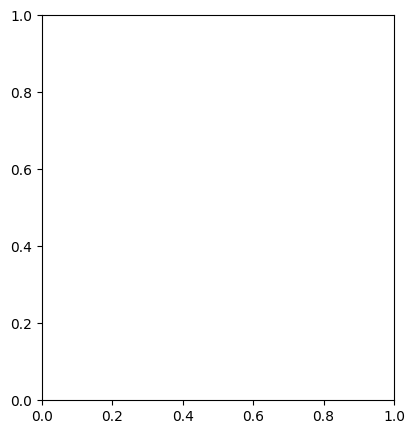

In [ ]:
plt.figure(figsize=[10,5])

plt.subplot(121)
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# #previous code
# from PIL import Image
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.model_selection import train_test_split
# from keras.models import Sequential
# from keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
# from keras.optimizers import Adam
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from imblearn.over_sampling import SMOTE
# import tensorflow as tf

# # Set memory growth configuration before initializing GPUs
# physical_devices = tf.config.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

# # Rest of your code
# # ... (hyperparameters, data loading, model building, etc.)


# # Hyperparameters
# B = 32  # Batch size
# LR = 0.0001  # Learning rate
# EPOCHS = 20  # Number of epochs
# VAL_SPLIT = 0.15
# HEIGHT = 299
# WIDTH = 299

# # Load your CSV
# csv_path = '/content/drive/MyDrive/cleaned_fileforread2000.csv'  # Update this path
# df = pd.read_csv(csv_path)

# target_columns = [
#     "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
#     "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
#     "Lung Opacity","No Finding", "Pleural Effusion", "Pleural Other",
#     "Pneumonia", "Pneumothorax","Support Devices"
# ]

# labels = df[target_columns].values
# df[target_columns] = df[target_columns].fillna(0)
# df[target_columns] = df[target_columns].applymap(lambda x: 0 if x < 0 else x)
# mlb = MultiLabelBinarizer()
# labels = mlb.fit_transform(labels)

# # Function to load images from paths and resize them
# def load_images(image_paths):
#     images = []
#     for index, path in enumerate(image_paths):
#         try:
#             img = Image.open(path).convert('RGB').resize((HEIGHT, WIDTH))
#             img_array = np.array(img)
#             images.append(img_array)
#         except Exception as e:
#             print(f"Error loading image {path}: {e}")
#     return np.array(images)

# image_paths = df['drive_path'].tolist()
# image_data = load_images(image_paths[:2000])

# # Split data into training and testing sets
# trainX, testX, trainY, testY = train_test_split(image_data, labels, test_size=VAL_SPLIT, random_state=42)

# # Manually oversample each label separately
# X_resampled = []
# y_resampled = []

# for label_index in range(trainY.shape[1]):
#     label_data = trainX[trainY[:, label_index] == 1]
#     label_labels = trainY[trainY[:, label_index] == 1]

#     # Calculate the difference between the majority and minority class
#     class_difference = len(label_labels) - np.sum(label_labels)

#     # Randomly sample data from the minority class with replacement
#     if class_difference > 0:
#         random_indices = np.random.choice(np.arange(len(label_data)), size=class_difference, replace=True)
#         X_res_label = label_data[random_indices]
#         y_res_label = label_labels[random_indices]

#         X_resampled.extend(X_res_label)
#         y_resampled.extend(y_res_label)

# X_resampled = np.array(X_resampled)
# y_resampled = np.array(y_resampled)

# # Model building function
# def buildModel(height, width, channels, classes):
#     model = Sequential()
#     inputShape = (height, width, channels)
#     model.add(Conv2D(64, (3,3), padding="same", input_shape=inputShape))
#     model.add(Activation("relu"))
#     model.add(BatchNormalization(axis=-1))

#     model.add(Conv2D(64, (3,3), padding="same"))
#     model.add(Activation("relu"))
#     model.add(BatchNormalization(axis=-1))

#     model.add(MaxPooling2D(pool_size=(3,3)))
#     model.add(Dropout(0.1))

#     model.add(Conv2D(128, (3,3), padding="same"))
#     model.add(Activation("relu"))
#     model.add(BatchNormalization(axis=-1))

#     model.add(Conv2D(128, (3,3), padding="same"))
#     model.add(Activation("relu"))
#     model.add(BatchNormalization(axis=-1))

#     model.add(MaxPooling2D(pool_size=(3,3)))
#     model.add(Dropout(0.2))

#     model.add(Conv2D(256, (3,3), padding="same"))
#     model.add(Activation("relu"))
#     model.add(BatchNormalization(axis=-1))

#     model.add(MaxPooling2D(pool_size=(3,3)))
#     model.add(Dropout(0.3))

#     model.add(Conv2D(512, (3,3), padding="same"))
#     model.add(Activation("relu"))
#     model.add(BatchNormalization(axis=-1))

#     model.add(MaxPooling2D(pool_size=(3,3)))
#     model.add(Dropout(0.4))

#     model.add(Flatten())
#     model.add(Dense(1024))
#     model.add(Activation("relu"))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))

#     model.add(Dense(classes))
#     model.add(Dense(classes, activation='sigmoid'))
#     return model

# model = buildModel(height=HEIGHT, width=WIDTH, channels=3, classes=len(mlb.classes_))
# adam = Adam(learning_rate=LR)
# model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])

# print("Beginning Training")
# H = model.fit(X_resampled, y_resampled, validation_data=(testX, testY),
#               batch_size=B, epochs=EPOCHS, verbose=1)
# # Plotting
# plt.figure(figsize=[10,5])

# # Plot Accuracy
# plt.subplot(121)
# plt.plot(H.history['accuracy'], label='Training Accuracy')
# plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# # Plot Loss
# plt.subplot(122)
# plt.plot(H.history['loss'], label='Training Loss')
# plt.plot(H.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()


In [ ]:
from tensorflow.keras.models import save_model
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
!pip install scikit-multilearn
from skmultilearn.model_selection import IterativeStratification
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.applications import VGG16
from keras.models import Model
from sklearn.model_selection import train_test_split
# Define F1-score metric
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))
data = pd.read_csv('/content/drive/MyDrive/cleaned_fileforread10000.csv')
labels = data[[
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", "Support Devices"
]].to_numpy()

target_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", "Support Devices"
]
data['drive_path'] = data['drive_path'].astype(str)
# Handle missing values
data[target_columns] = data[target_columns].fillna(0)
data[target_columns] = data[target_columns].applymap(lambda x: 0 if x < 0 else x)
# Function to create custom CNN model
def buildModel(height, width, channels, classes):
    model = Sequential()
    inputShape = (height, width, channels)
    model.add(Conv2D(64, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))

    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.1))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))

    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))

    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))

    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Dense(classes, activation='sigmoid'))
    return model

n_folds = 8
stratified_kf = IterativeStratification(n_splits=n_folds, order=1)

# Data Augmentation
datagen = ImageDataGenerator(rescale=1./255.)

# Initialize a list to store the history objects
all_histories = []

# Initialize variable to store the best validation loss
best_val_loss = float('inf')

height, width, channels, classes = 299, 299, 3, len(target_columns)
model = buildModel(height, width, channels, classes)
model.compile(optimizer=Adam(learning_rate=0.00005),
              loss='binary_crossentropy',
              metrics=[Precision(), Recall(), f1_score, 'accuracy'])
for i, (train, test) in enumerate(stratified_kf.split(data, labels)):
    print(f"Training on Fold: {i+1}")

    train_data = data.iloc[train]
    test_data = data.iloc[test]

    train_generator = datagen.flow_from_dataframe(train_data, x_col="drive_path", y_col=target_columns,
                                                  target_size=(299, 299), class_mode='raw', batch_size=32)
    test_generator = datagen.flow_from_dataframe(test_data, x_col="drive_path", y_col=target_columns,
                                                 target_size=(299, 299), class_mode='raw', batch_size=32)

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    history = model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping, reduce_lr])

    # Store the history
    all_histories.append(history.history)

    current_val_loss = min(history.history['val_loss'])
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        save_model(model, "/content/drive/MyDrive/best_model10000scratch.h5")
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks([i / 10 for i in range(1, 10)])
plt.ylim(0.1, 0.8)
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.2 MB/s eta 0:00:00
Training on Fold: 1


In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from keras.models import load_model
from keras import backend as K
from tensorflow.keras.metrics import Precision, Recall
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))
loaded_model = load_model("/content/drive/MyDrive/best_model10000scratch.h5", custom_objects={'f1_score': f1_score})

csv_path = '/content/drive/MyDrive/p11_report.csv'
data = pd.read_csv(csv_path)

target_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", "Support Devices"
]
true_label_count = 0
correct_predictions = 0

incorrectly_predicted_paths = []

for index, row in data.iloc[:500].iterrows():
    img_path = row['image-path']
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = loaded_model.predict(img_array)[0]

    pred_label_indices = [i for i, p in enumerate(prediction) if p > 0.4]
    pred_labels = [target_columns[i] for i in pred_label_indices]

    true_labels = [col for col in target_columns if col in row['label']]

    true_label_count += len(true_labels)
    correct_predictions += len(set(true_labels) & set(pred_labels))

    if set(true_labels) != set(pred_labels):
        incorrectly_predicted_paths.append({"image-path": img_path})

    print(f"Image {index + 1}:\nTrue Labels: {true_labels}\nPredicted Labels: {pred_labels}\n")

overall_accuracy = correct_predictions / true_label_count * 100
print(f"Overall Accuracy: {overall_accuracy:.2f}%")

incorrectly_predicted_df = pd.DataFrame(incorrectly_predicted_paths)

incorrectly_predicted_df.to_csv("not_correct.csv", index=False)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import cv2
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import normalize

df = pd.read_csv('/content/drive/MyDrive/50.csv')

target_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", "Support Devices"
]

df[target_columns] = df[target_columns].fillna(0)
df[target_columns] = df[target_columns].applymap(lambda x: 0 if x < 0 else x)

images = []
labels = []

for index, row in df.iterrows():
    img_path = row['drive_path']
    label = row[target_columns].to_numpy()
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    img_equalized = cv2.equalizeHist(img)

    img_array = cv2.cvtColor(img_equalized, cv2.COLOR_GRAY2BGR)  # Convert to 3-channel array
    flattened_img_array = img_array.flatten()
    images.append(flattened_img_array)
    labels.append(label)

X = np.array(images)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

resampled_dfs = []
smote = SMOTE(sampling_strategy='auto', random_state=42)
for i, col in enumerate(target_columns):
    y_current = y_train[:, i].ravel().astype('int')
    if np.sum(y_current) < 2:
        print(f"Skipping {col} due to insufficient samples.")
        continue
    k_neighbors = min(5, np.sum(y_current) - 1)
    smote.set_params(k_neighbors=k_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_current)
    y_resampled_df = pd.DataFrame({col: y_resampled})
    resampled_dfs.append(y_resampled_df)

final_resampled_df = pd.concat(resampled_dfs, axis=1)

final_resampled_df.fillna(0, inplace=True)
print("Resampled class distribution:")
print(final_resampled_df.sum())
y_resampled = final_resampled_df.to_numpy().astype('float32')

X_resampled_images = np.array([x.reshape(299, 299, 3) for x in X_resampled])
X_resampled_images = normalize(X_resampled_images, axis=1)




Skipping Fracture due to insufficient samples.
Skipping Lung Lesion due to insufficient samples.
Skipping Pleural Other due to insufficient samples.
Resampled class distribution:
Atelectasis                   34.0
Cardiomegaly                  24.0
Consolidation                 38.0
Edema                         31.0
Enlarged Cardiomediastinum    38.0
Lung Opacity                  37.0
No Finding                    28.0
Pleural Effusion              23.0
Pneumonia                     38.0
Pneumothorax                  38.0
Support Devices               23.0
dtype: float64


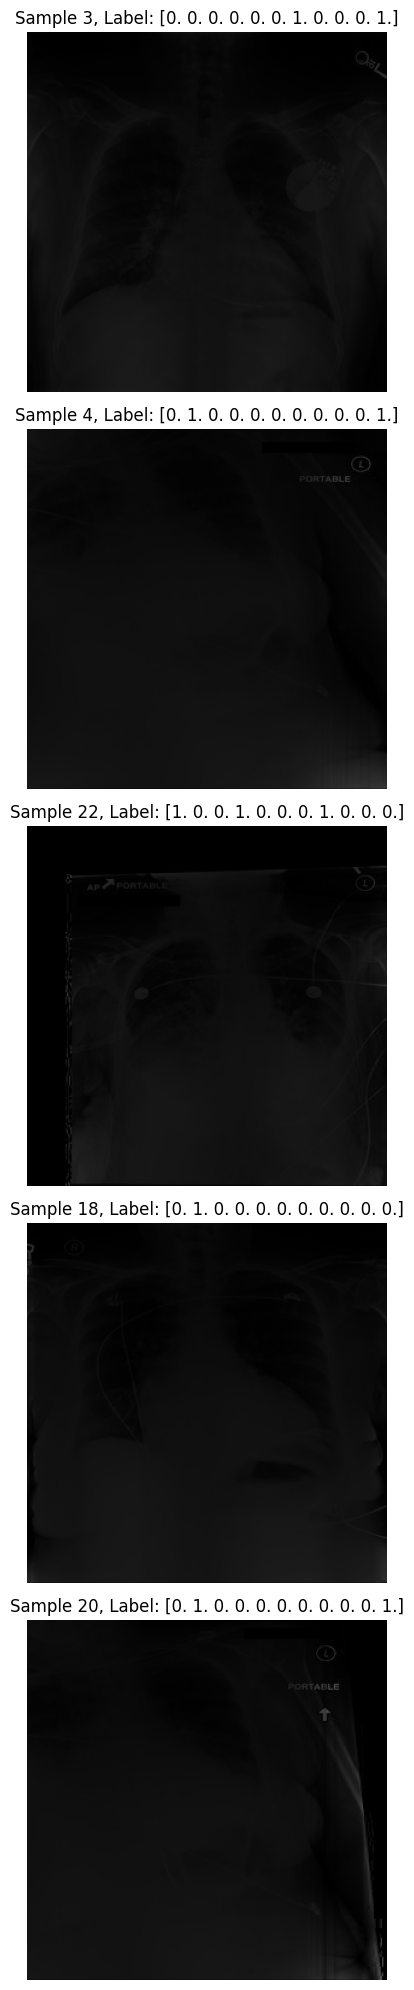

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_samples_to_visualize = 5
sample_indices = np.random.choice(len(X_resampled_images), num_samples_to_visualize, replace=False)

fig, axes = plt.subplots(num_samples_to_visualize, 1, figsize=(20, 20))

for i, sample_index in enumerate(sample_indices):
    ax = axes[i]
    image = X_resampled_images[sample_index]
    if sample_index < len(y_resampled):
        label = y_resampled[sample_index]
        ax.set_title(f"Sample {sample_index}, Label: {label}")
    else:
        ax.set_title(f"Sample {sample_index}, Label: N/A (Out of Range)")

    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import normalize

df = pd.read_csv('/content/drive/MyDrive/50.csv')

target_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", "Support Devices"
]

df[target_columns] = df[target_columns].fillna(0)
df[target_columns] = df[target_columns].applymap(lambda x: 0 if x < 0 else x)

images = []
labels = []

for index, row in df.iterrows():
    img_path = row['drive_path']
    label = row[target_columns].to_numpy()
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_array = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    flattened_img_array = img_array / 255.0
    images.append(flattened_img_array)
    labels.append(label)

X = np.array(images)
y = np.array(labels)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen.fit(X)

X_augmented = []
y_augmented = []

for i in range(len(X)):
    for _ in range(5):
        augmented_image = datagen.random_transform(X[i])
        X_augmented.append(augmented_image)
        y_augmented.append(y[i])

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)


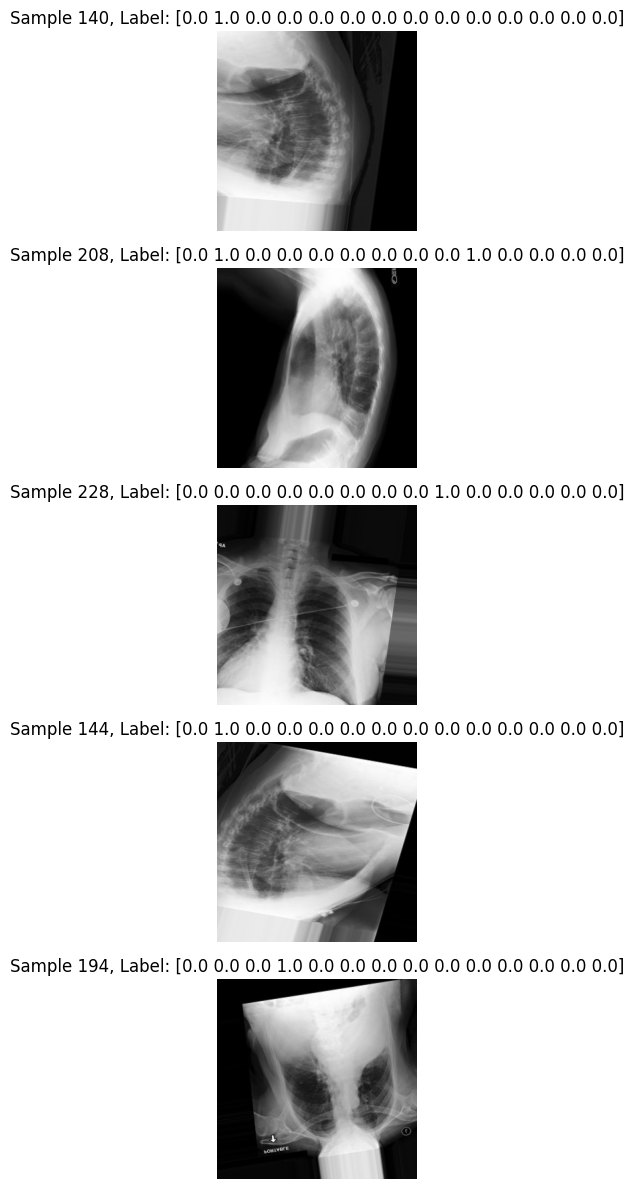

In [ ]:
import matplotlib.pyplot as plt

def visualize_augmented_data(X, y, num_samples=5):
    sample_indices = np.random.choice(len(X), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 1, figsize=(8, 12))

    for i, sample_index in enumerate(sample_indices):
        ax = axes[i]
        augmented_image = X[sample_index]
        label = y[sample_index]

        ax.imshow(augmented_image)
        ax.axis('off')
        ax.set_title(f"Sample {sample_index}, Label: {label}")

    plt.tight_layout()
    plt.show()

# Visualize augmented data
visualize_augmented_data(X_augmented, y_augmented, num_samples=5)


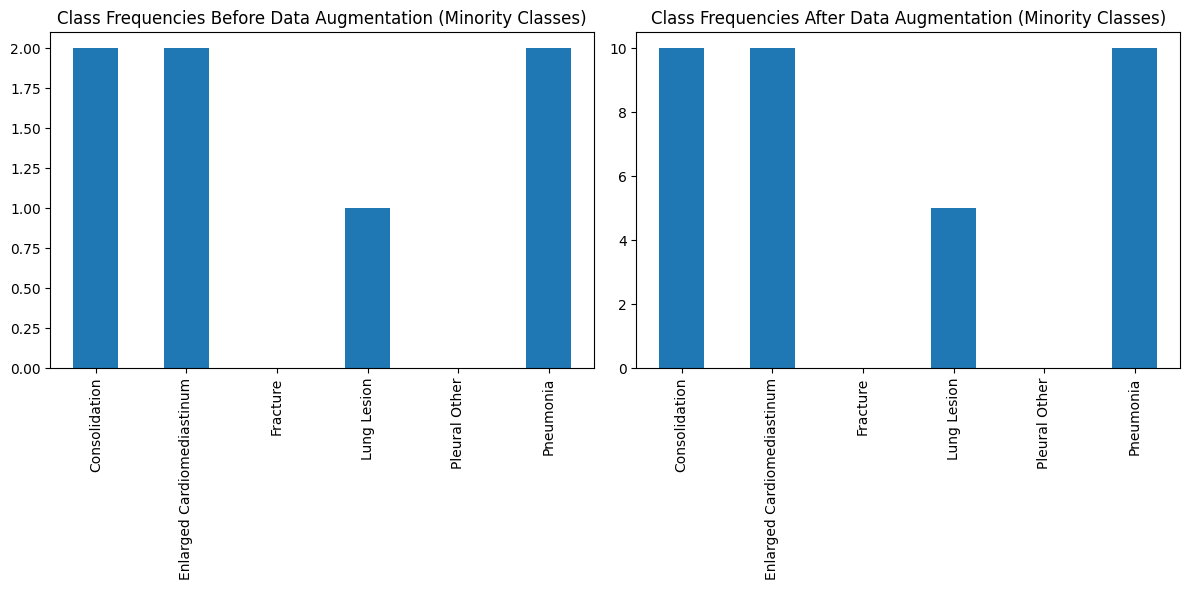

In [ ]:
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import normalize
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/50.csv')

target_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", "Support Devices"
]

df[target_columns] = df[target_columns].fillna(0)
df[target_columns] = df[target_columns].applymap(lambda x: 0 if x < 0 else x)

minority_classes = target_columns  # Start with all classes
minority_threshold = 3  # Set a threshold for what constitutes a minority class

class_frequencies = df[target_columns].sum()

minority_classes = [col for col in target_columns if class_frequencies[col] < minority_threshold]

class_frequencies_before = df[minority_classes].sum()

images = []
labels = []

for index, row in df.iterrows():
    img_path = row['drive_path']
    label = row[target_columns].to_numpy()
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_array = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert to 3-channel array
    flattened_img_array = img_array / 255.0  # Normalize the image
    images.append(flattened_img_array)
    labels.append(label)

X = np.array(images)
y = np.array(labels)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen.fit(X)

X_augmented = []
y_augmented = []

for i in range(len(X)):
    if any(y[i]) and any([col in minority_classes for col in target_columns]):
        # Check if the image has any class label and if it's in the minority classes
        for _ in range(5):  # You can adjust the number of augmentations per image
            augmented_image = datagen.random_transform(X[i])
            X_augmented.append(augmented_image)
            y_augmented.append(y[i])
    else:
        X_augmented.append(X[i])
        y_augmented.append(y[i])

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

augmented_df = pd.DataFrame(y_augmented, columns=target_columns)

class_frequencies_after = augmented_df[minority_classes].sum()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
class_frequencies_before.plot(kind='bar', title='Class Frequencies Before Data Augmentation (Minority Classes)')
plt.subplot(1, 2, 2)
class_frequencies_after.plot(kind='bar', title='Class Frequencies After Data Augmentation (Minority Classes)')
plt.tight_layout()
plt.show()


['Consolidation', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Pleural Other', 'Pneumonia']


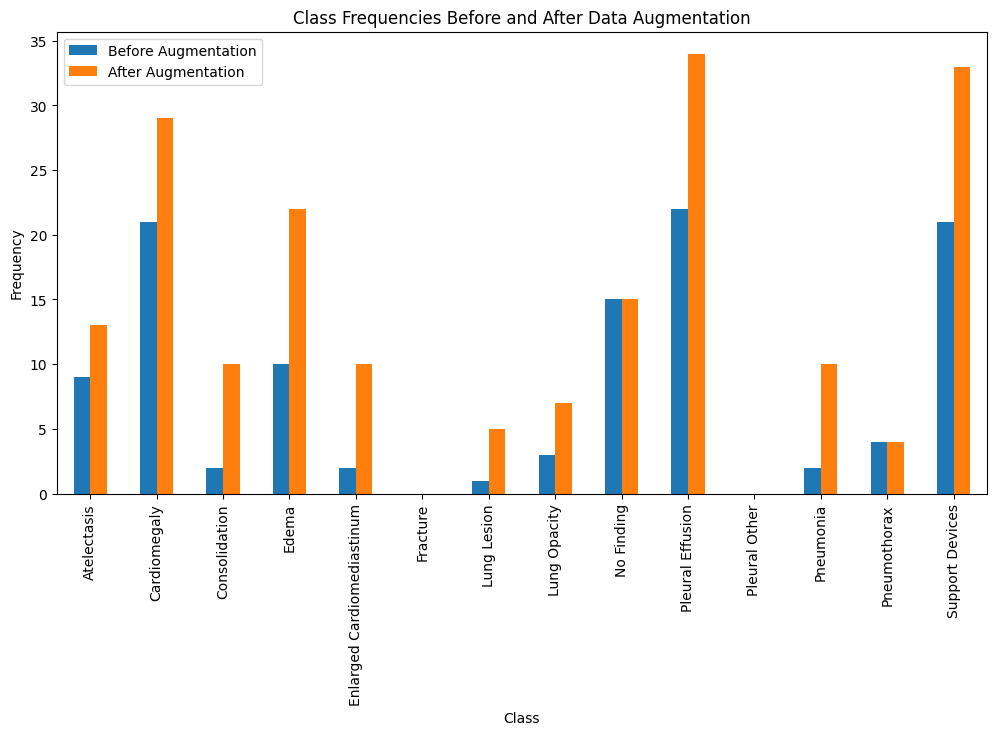

In [ ]:
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import normalize
import matplotlib.pyplot as plt
df = pd.read_csv('/content/drive/MyDrive/50.csv')

target_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", "Support Devices"
]

df[target_columns] = df[target_columns].fillna(0)
df[target_columns] = df[target_columns].applymap(lambda x: 0 if x < 0 else x)

minority_classes = target_columns  # Start with all classes
minority_threshold = 3  # Set a threshold for what constitutes a minority class

# Calculate class frequencies
class_frequencies = df[target_columns].sum()

# Identify minority classes based on the threshold
minority_classes = [col for col in target_columns if class_frequencies[col] < minority_threshold]
print(minority_classes)

images = []
labels = []

for index, row in df.iterrows():
    img_path = row['drive_path']
    label = row[target_columns].to_numpy()
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_array = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert to 3-channel array
    flattened_img_array = img_array / 255.0  # Normalize the image
    images.append(flattened_img_array)
    labels.append(label)

X = np.array(images)
y = np.array(labels)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(X)

X_augmented = []
y_augmented = []

for i in range(len(X)):
    has_minority_class = any(y[i][[target_columns.index(col) for col in minority_classes]])

    if has_minority_class:
        for _ in range(5):  # You can adjust the number of augmentations per image
            augmented_image = datagen.random_transform(X[i])
            X_augmented.append(augmented_image)
            y_augmented.append(y[i])
    else:
        X_augmented.append(X[i])
        y_augmented.append(y[i])

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

augmented_df = pd.DataFrame(y_augmented, columns=target_columns)


class_frequencies_before = df[target_columns].sum()

class_frequencies_after = augmented_df[target_columns].sum()

combined_class_frequencies = pd.concat([class_frequencies_before, class_frequencies_after], axis=1)
combined_class_frequencies.columns = ['Before Augmentation', 'After Augmentation']

combined_class_frequencies.plot(kind='bar', figsize=(12, 6))
plt.title('Class Frequencies Before and After Data Augmentation')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


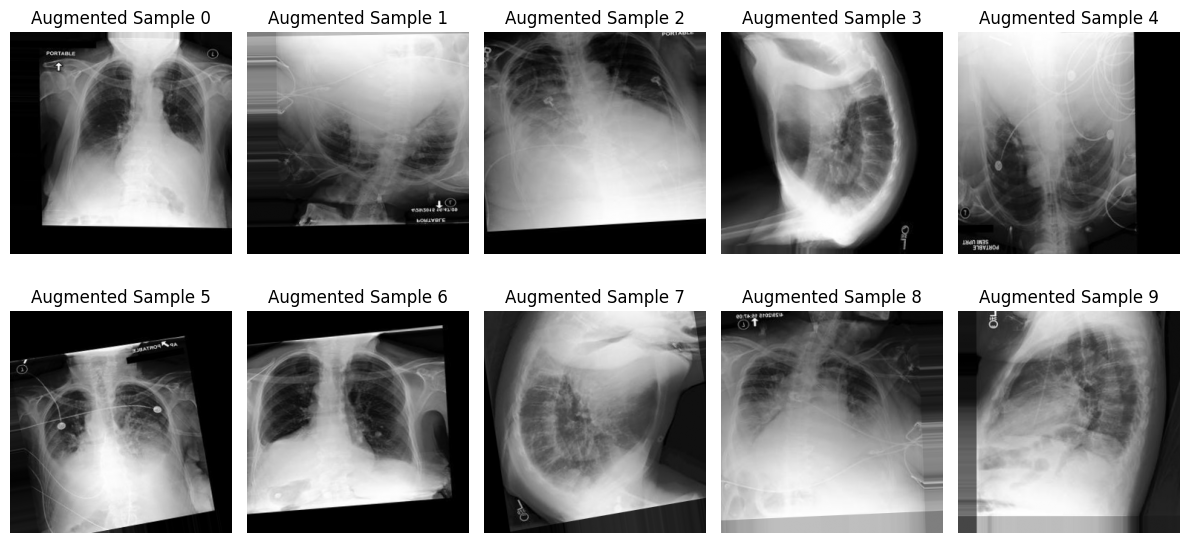

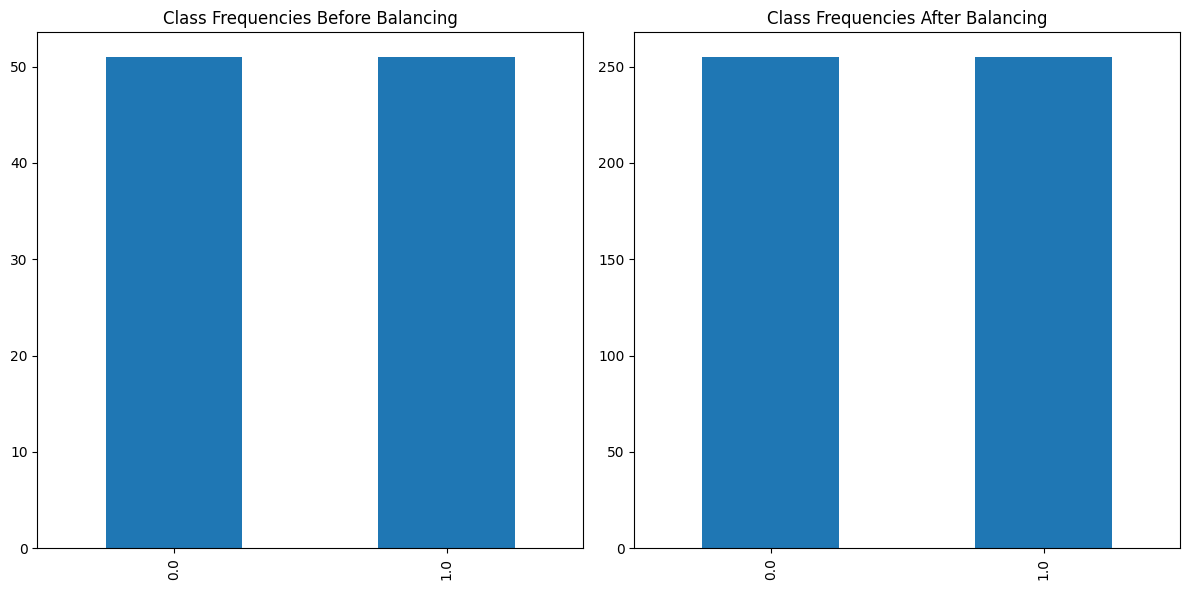

In [ ]:
import numpy as np
import pandas as pd
import cv2
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/50.csv')

target_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", "Support Devices"
]

df[target_columns] = df[target_columns].fillna(0)
df[target_columns] = df[target_columns].applymap(lambda x: 0 if x < 0 else x)

images = []
labels = []

for index, row in df.iterrows():
    img_path = row['drive_path']
    label = row[target_columns].to_numpy()
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_array = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert to 3-channel array
    flattened_img_array = img_array / 255.0  # Normalize the image
    images.append(flattened_img_array)
    labels.append(label)

X = np.array(images)
y = np.array(labels)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen.fit(X)

minority_threshold = 100
combination_frequencies_before = pd.DataFrame(y, columns=mlb.classes_).sum()
minority_combinations = combination_frequencies_before[combination_frequencies_before < minority_threshold].index

X_augmented = []
y_augmented = []

for i, labels in enumerate(y):
    if any(label in minority_combinations for label in labels):
        for _ in range(5):  # You can adjust the number of augmentations per image
            augmented_image = datagen.random_transform(X[i])
            X_augmented.append(augmented_image)
            y_augmented.append(y[i])
    else:
        # Keep the original sample
        X_augmented.append(X[i])
        y_augmented.append(y[i])

X_augmented, y_augmented = shuffle(X_augmented, y_augmented, random_state=42)

# Calculate the frequency of each combination of classes before and after balancing
combination_frequencies_before = pd.DataFrame(y, columns=mlb.classes_).sum()
combination_frequencies_after = pd.DataFrame(y_augmented, columns=mlb.classes_).sum()

# Display some augmented data samples
plt.figure(figsize=(12, 6))
for i in range(10):  # Adjust the number of samples to display
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_augmented[i])
    plt.title(f"Augmented Sample {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Visualize class frequencies before and after balancing
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
combination_frequencies_before.plot(kind='bar', title='Class Frequencies Before Balancing')
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
combination_frequencies_after.plot(kind='bar', title='Class Frequencies After Balancing')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

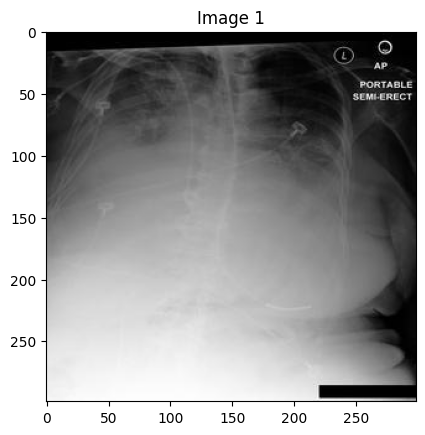

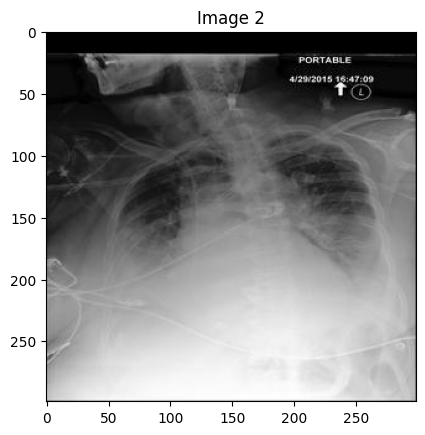

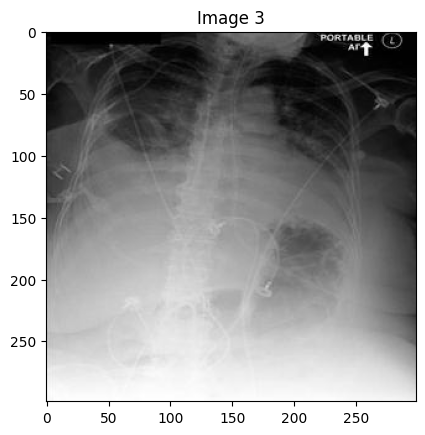

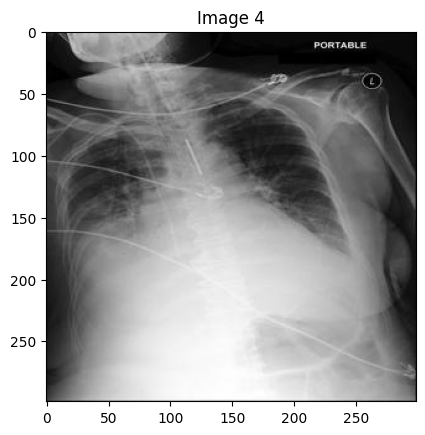

Skipping Fracture due to insufficient samples.
Skipping Lung Lesion due to insufficient samples.
Skipping Pleural Other due to insufficient samples.
Resampled class distribution:
Atelectasis                   34.0
Cardiomegaly                  24.0
Consolidation                 38.0
Edema                         31.0
Enlarged Cardiomediastinum    38.0
Lung Opacity                  37.0
No Finding                    28.0
Pleural Effusion              23.0
Pneumonia                     38.0
Pneumothorax                  38.0
Support Devices               23.0
dtype: float64


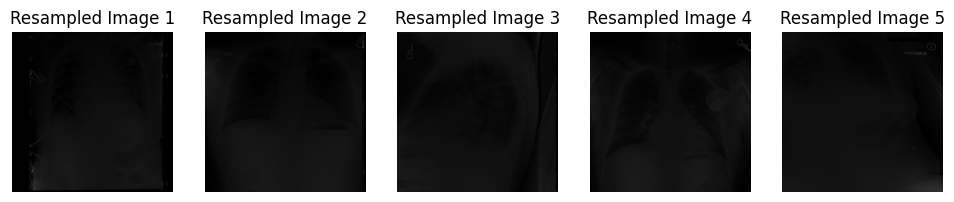

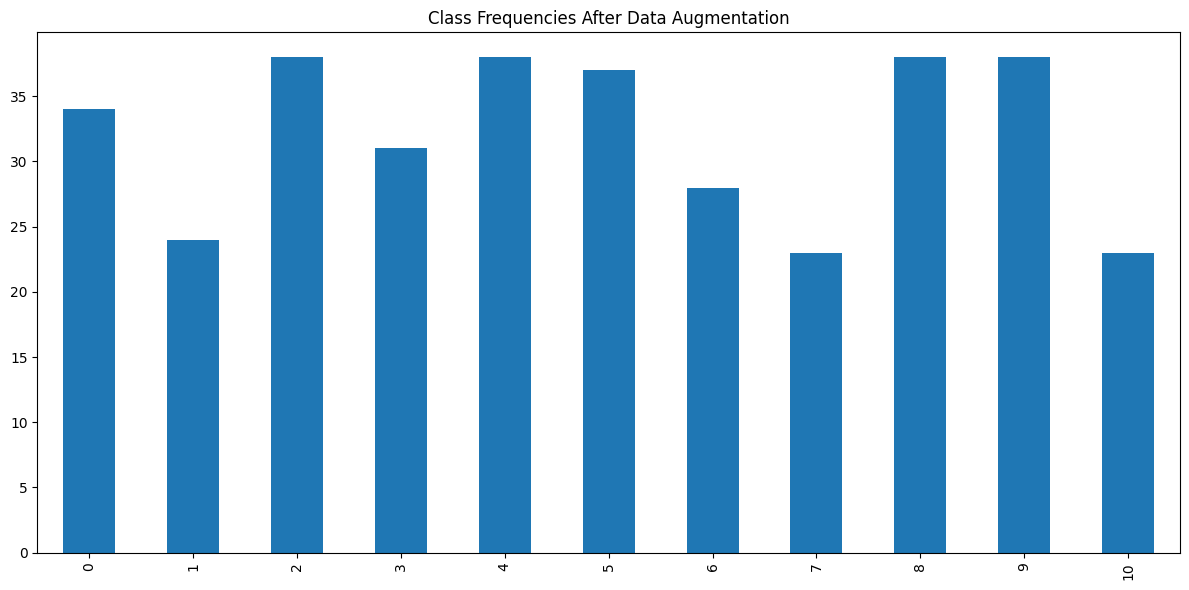

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import cv2
from tensorflow.keras.utils import normalize
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/50.csv')

target_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", "Support Devices"
]

df[target_columns] = df[target_columns].fillna(0)
df[target_columns] = df[target_columns].applymap(lambda x: 0 if x < 0 else x)

images = []
for index, row in df.iterrows():
    img_path = row['drive_path']
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img_rgb)
    if len(images) < 5:
        plt.figure()
        plt.imshow(img_rgb)
        plt.title(f"Image {index + 1}")

plt.show()

X = np.array(images)

y = df[target_columns].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_flattened = X_train.reshape(X_train.shape[0], -1)

resampled_dfs = []
smote = SMOTE(sampling_strategy='auto', random_state=42)
for i, col in enumerate(target_columns):
    y_current = y_train[:, i].ravel().astype('int')
    if np.sum(y_current) < 2:
        print(f"Skipping {col} due to insufficient samples.")
        continue
    k_neighbors = min(5, np.sum(y_current) - 1)
    smote.set_params(k_neighbors=k_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X_train_flattened, y_current)
    y_resampled_df = pd.DataFrame({col: y_resampled})
    resampled_dfs.append(y_resampled_df)

final_resampled_df = pd.concat(resampled_dfs, axis=1)

final_resampled_df.fillna(0, inplace=True)

print("Resampled class distribution:")
print(final_resampled_df.sum())

y_resampled = final_resampled_df.to_numpy().astype('float32')

X_resampled_images = np.array([x.reshape(299, 299, 3) for x in X_resampled])
X_resampled_images = normalize(X_resampled_images, axis=1)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_resampled_images[i])
    plt.title(f"Resampled Image {i + 1}")
    plt.axis('off')

plt.figure(figsize=(12, 6))
pd.DataFrame(y_resampled).sum().plot(kind='bar', title='Class Frequencies After Data Augmentation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


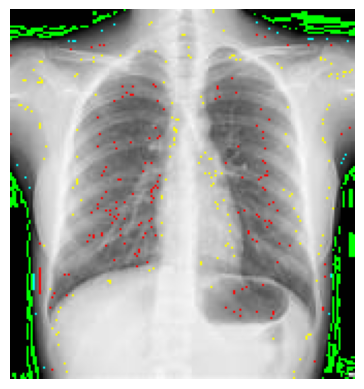

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open("/content/WhatsApp Image 2023-09-07 at 4.06.31 PM.jpeg")

img_array = np.array(img)

color_mapping = {
    (128, 128, 128): (255, 0, 0),  # Replace gray with red
    (255, 255, 255): (0, 255, 0),  # Replace white with green
    (0, 0, 0): (0, 255, 0),       # Replace black with blue
    (192, 192, 192):(255, 255, 0),
    (64, 64, 64):(0, 255, 255)
}

for old_color, new_color in color_mapping.items():
    img_array[(img_array == old_color).all(axis=-1)] = new_color

plt.imshow(img_array)
plt.axis('off')
plt.show()


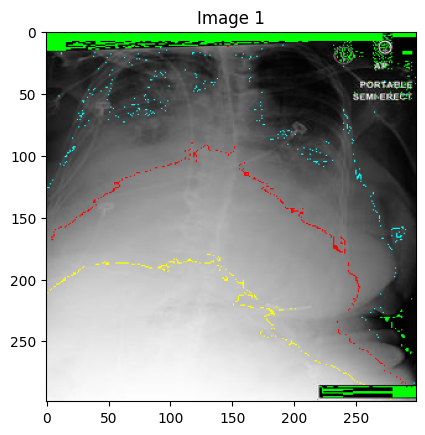

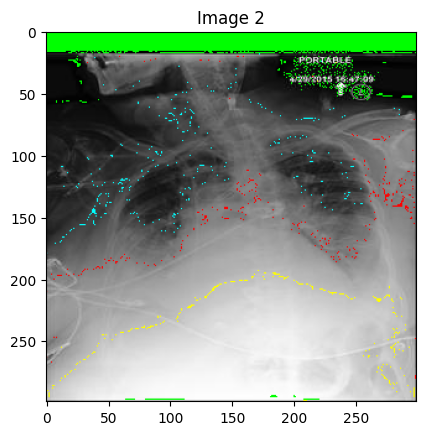

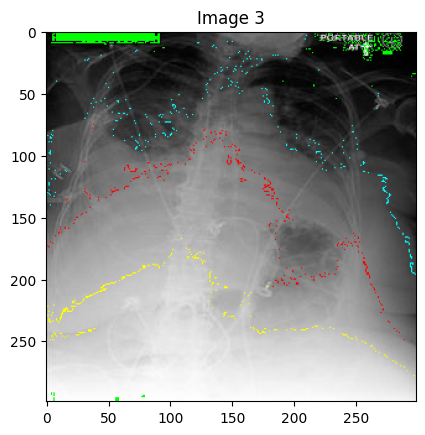

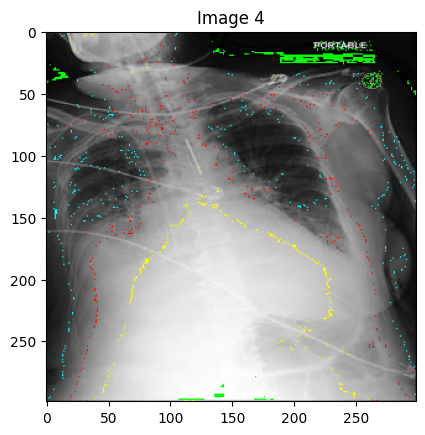

Skipping Fracture due to insufficient samples.
Skipping Lung Lesion due to insufficient samples.
Skipping Pleural Other due to insufficient samples.
Resampled class distribution:
Atelectasis                   34.0
Cardiomegaly                  24.0
Consolidation                 38.0
Edema                         31.0
Enlarged Cardiomediastinum    38.0
Lung Opacity                  37.0
No Finding                    28.0
Pleural Effusion              23.0
Pneumonia                     38.0
Pneumothorax                  38.0
Support Devices               23.0
dtype: float64


ValueError: ignored

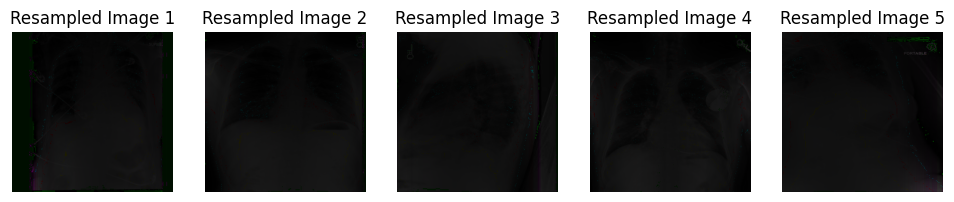

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import cv2
from tensorflow.keras.utils import normalize
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/50.csv')

target_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", "Support Devices"
]

df[target_columns] = df[target_columns].fillna(0)
df[target_columns] = df[target_columns].applymap(lambda x: 0 if x < 0 else x)

images = []
color_mapping = {
    (128, 128, 128): (255, 0, 0),    # Replace gray with red
    (255, 255, 255): (0, 255, 0),    # Replace white with green
    (0, 0, 0): (0, 255, 0),          # Replace black with blue
    (192, 192, 192): (255, 255, 0),  # Replace certain gray with yellow
    (64, 64, 64): (0, 255, 255)     # Replace certain gray with cyan
}

for index, row in df.iterrows():
    img_path = row['drive_path']
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read the image in color format
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format

    for old_color, new_color in color_mapping.items():
        img_rgb[(img_rgb == old_color).all(axis=-1)] = new_color

    images.append(img_rgb)

    if len(images) < 5:
        plt.figure()
        plt.imshow(img_rgb)  # Display image in RGB format
        plt.title(f"Image {index + 1}")

plt.show()

X = np.array(images)

y = df[target_columns].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_flattened = X_train.reshape(X_train.shape[0], -1)

resampled_dfs = []
smote = SMOTE(sampling_strategy='auto', random_state=42)
for i, col in enumerate(target_columns):
    y_current = y_train[:, i].ravel().astype('int')
    if np.sum(y_current) < 2:
        print(f"Skipping {col} due to insufficient samples.")
        continue
    k_neighbors = min(5, np.sum(y_current) - 1)
    smote.set_params(k_neighbors=k_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X_train_flattened, y_current)

    X_resampled_rgb = np.array([x.reshape(X_train.shape[1:]) for x in X_resampled])
    for old_color, new_color in color_mapping.items():
        X_resampled_rgb[(X_resampled_rgb == old_color).all(axis=-1)] = new_color

    y_resampled_df = pd.DataFrame({col: y_resampled})
    resampled_dfs.append(y_resampled_df)

final_resampled_df = pd.concat(resampled_dfs, axis=1)

final_resampled_df.fillna(0, inplace=True)

print("Resampled class distribution:")
print(final_resampled_df.sum())

y_resampled = final_resampled_df.to_numpy().astype('float32')

X_resampled_images = normalize(X_resampled_rgb, axis=1)

plt.figure(figsize=(12, 6))
for i in range(100):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_resampled_images[i])
    plt.title(f"Resampled Image {i + 1}")
    plt.axis('off')

plt.figure(figsize=(12, 6))
pd.DataFrame(y_resampled).sum().plot(kind='bar', title='Class Frequencies After Data Augmentation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

for i in range(len(X_resampled_images)):
    plt.figure(figsize=(5, 5))  # Adjust the figsize as needed for larger size
    plt.imshow(X_resampled_images[i])
    plt.title(f"Sample {i + 1}")
    plt.axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
X_resampled_images

array([[[[0.        , 0.05783149, 0.        ],
         [0.        , 0.05783149, 0.        ],
         [0.        , 0.05783149, 0.        ],
         ...,
         [0.        , 0.05783149, 0.        ],
         [0.        , 0.05783149, 0.        ],
         [0.        , 0.05783149, 0.        ]],

        [[0.        , 0.05783149, 0.        ],
         [0.        , 0.05783149, 0.        ],
         [0.        , 0.05783149, 0.        ],
         ...,
         [0.        , 0.05783149, 0.        ],
         [0.        , 0.05783149, 0.        ],
         [0.        , 0.05783149, 0.        ]],

        [[0.        , 0.05783149, 0.        ],
         [0.        , 0.05783149, 0.        ],
         [0.        , 0.05783149, 0.        ],
         ...,
         [0.        , 0.05783149, 0.        ],
         [0.        , 0.05783149, 0.        ],
         [0.        , 0.05783149, 0.        ]],

        ...,

        [[0.        , 0.05783149, 0.        ],
         [0.        , 0.05783149, 0.        ]

In [ ]:
y_resampled

array([[0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.],
       [1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.

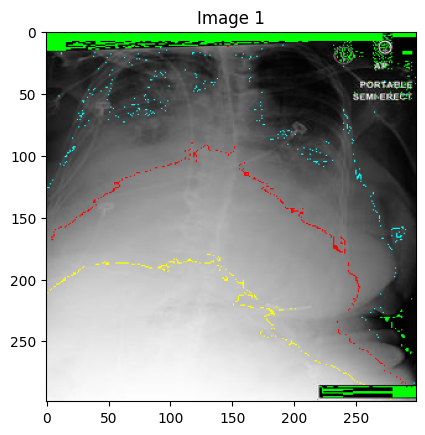

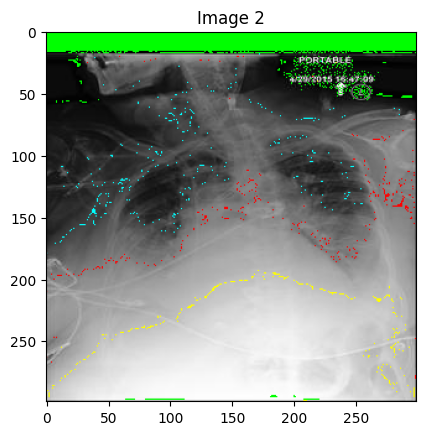

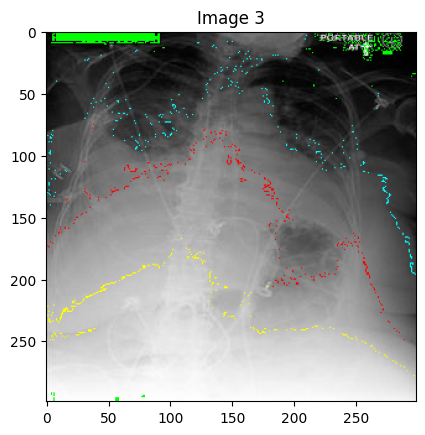

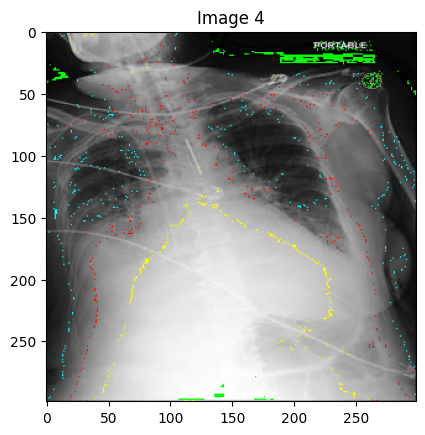

Skipping Fracture due to insufficient samples.
Skipping Lung Lesion due to insufficient samples.
Skipping Pleural Other due to insufficient samples.
Resampled class distribution:
Atelectasis                   34.0
Cardiomegaly                  24.0
Consolidation                 38.0
Edema                         31.0
Enlarged Cardiomediastinum    38.0
Lung Opacity                  37.0
No Finding                    28.0
Pleural Effusion              23.0
Pneumonia                     38.0
Pneumothorax                  38.0
Support Devices               23.0
dtype: float64


ValueError: ignored

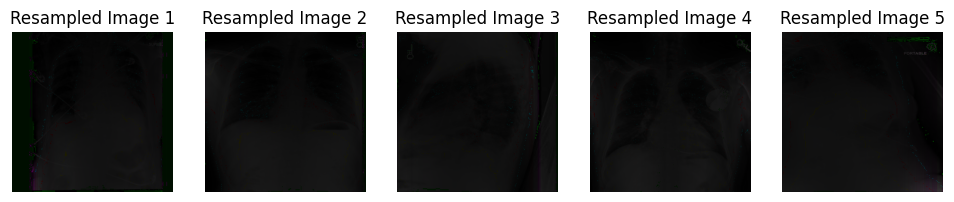

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import cv2
from tensorflow.keras.utils import normalize
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/50.csv')

# Handle missing values in target columns
target_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", "Support Devices"
]

df[target_columns] = df[target_columns].fillna(0)
df[target_columns] = df[target_columns].applymap(lambda x: 0 if x < 0 else x)

images = []
color_mapping = {
    (128, 128, 128): (255, 0, 0),    # Replace gray with red
    (255, 255, 255): (0, 255, 0),    # Replace white with green
    (0, 0, 0): (0, 255, 0),          # Replace black with blue
    (192, 192, 192): (255, 255, 0),  # Replace certain gray with yellow
    (64, 64, 64): (0, 255, 255)     # Replace certain gray with cyan
}

for index, row in df.iterrows():
    img_path = row['drive_path']
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read the image in color format
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format

    for old_color, new_color in color_mapping.items():
        img_rgb[(img_rgb == old_color).all(axis=-1)] = new_color

    images.append(img_rgb)

    if len(images) < 5:
        plt.figure()
        plt.imshow(img_rgb)  # Display image in RGB format
        plt.title(f"Image {index + 1}")

plt.show()

X_original = np.array(images)

# Convert labels to binary format (0 or 1 for each class)
y_original = df[target_columns].values

X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

X_train_flattened = X_train_original.reshape(X_train_original.shape[0], -1)

resampled_dfs = []
smote = SMOTE(sampling_strategy='auto', random_state=42)
for i, col in enumerate(target_columns):
    y_current = y_train_original[:, i].ravel().astype('int')
    if np.sum(y_current) < 2:
        print(f"Skipping {col} due to insufficient samples.")
        continue
    k_neighbors = min(5, np.sum(y_current) - 1)
    smote.set_params(k_neighbors=k_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X_train_flattened, y_current)

    X_resampled_rgb = np.array([x.reshape(X_train_original.shape[1:]) for x in X_resampled])
    for old_color, new_color in color_mapping.items():
        X_resampled_rgb[(X_resampled_rgb == old_color).all(axis=-1)] = new_color

    y_resampled_df = pd.DataFrame({col: y_resampled})
    resampled_dfs.append(y_resampled_df)

final_resampled_df = pd.concat(resampled_dfs, axis=1)

final_resampled_df.fillna(0, inplace=True)

print("Resampled class distribution:")
print(final_resampled_df.sum())

y_resampled = final_resampled_df.to_numpy().astype('float32')

X_resampled_images = normalize(X_resampled_rgb, axis=1)

plt.figure(figsize=(12, 6))
for i in range(100):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_resampled_images[i])
    plt.title(f"Resampled Image {i + 1}")
    plt.axis('off')

plt.figure(figsize=(12, 6))
pd.DataFrame(y_resampled).sum().plot(kind='bar', title='Class Frequencies After Data Augmentation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

df = pd.read_csv('/content/drive/MyDrive/50.csv')

target_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", "Support Devices"
]

df[target_columns] = df[target_columns].fillna(0)
df[target_columns] = df[target_columns].applymap(lambda x: 0 if x < 0 else x)

images = []
for index, row in df.iterrows():
    img_path = row['drive_path']
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read the image in color format
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    images.append(img_rgb)

X_real = np.array(images)

y_real = df[target_columns].values

height = 299
width = 299
channels = 3
img_shape = (height, width, channels)
latent_dim = 100
gan_epochs = 10000
gan_batch_size = 32

def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    return model

def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

for epoch in range(gan_epochs):
    idx = np.random.randint(0, X_real.shape[0], gan_batch_size)
    real_images = X_real[idx]
    real_labels = np.ones((gan_batch_size, 1))

    noise = np.random.normal(0, 1, (gan_batch_size, latent_dim))
    generated_images = generator.predict(noise)
    fake_labels = np.zeros((gan_batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (gan_batch_size, latent_dim))
    valid_labels = np.ones((gan_batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_labels)

    if epoch % 100 == 0:
        print(f"GAN Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

        noise = np.random.normal(0, 1, (1, latent_dim))
        generated_image = generator.predict(noise)[0]

        plt.figure()
        plt.imshow(generated_image)
        plt.title(f"Generated Image (Epoch {epoch})")
        plt.axis('off')
        plt.show()
        plt.pause(1)  # Pause for 1 second to view the image

        noise = np.random.normal(0, 1, (1, latent_dim))
        generated_image = generator.predict(noise)[0]

        for i, image in enumerate(generated_images):
            cv2.imwrite(f"generated_image_{epoch}_{i}.png", cv2.cvtColor(image * 255, cv2.COLOR_RGB2BGR))

synthetic_images = generator.predict(np.random.normal(0, 1, (X_real.shape[0], latent_dim)))

y_synthetic = np.zeros_like(y_real)

X_combined = np.concatenate((X_real, synthetic_images), axis=0)
y_combined = np.concatenate((y_real, y_synthetic), axis=0)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
class_counts = np.sum(y_combined, axis=0)
for i, class_name in enumerate(target_columns):
    print(f"{class_name}: {class_counts[i]} samples")


In [ ]:
num_samples_per_class = 5  # Adjust the number of samples to show per class

for i, class_name in enumerate(target_columns):
    class_indices = np.where(y_combined[:, i] == 1)[0]
    class_samples = X_combined[class_indices][:num_samples_per_class]

    for j, sample_image in enumerate(class_samples):
        plt.figure()
        plt.imshow(sample_image)
        plt.title(f"Class: {class_name} - Sample {j + 1}")
        plt.axis('off')
        plt.show()
